#Imports

In [1]:
import pandas as pd
from tqdm import tqdm
import requests
import matplotlib.pyplot as plt
import numpy as np

#EDA

##Criação do Conjunto de Dados princial

In [2]:
#Obtém os dados originais do site da ONS
def get_raw_data(ano):
  url = f'https://ons-aws-prod-opendata.s3.amazonaws.com/dataset/geracao_usina_2_ho/GERACAO_USINA_{ano}.csv'
  return pd.read_csv(url, sep=';')

#Elimina as colunas que não irão contribuir para o modelo
def drop_columns(df):
  #Lista colunas redundantes
  colunas_redundantes = ['id_subsistema', 'id_estado', 'ceg']

  #Lista colunas irrelevantes para o problema
  colunas_irrelevantes = ['cod_modalidadeoperacao']

  #Exclui colunas redundantes ou irrelevantes
  df_clean = df.drop(columns=colunas_redundantes+colunas_irrelevantes)
  return df_clean

#Agrupa os valores de geração de energia por mês
def group_by_month(df):
  # Convertendo a coluna 'din_instante' para o tipo datetime e convertendo para o formato yyyy-mm
  df['din_instante'] = pd.to_datetime(df['din_instante'])

  df_grouped_by_hour = df.groupby('din_instante')['val_geracao'].sum().reset_index()
  df_grouped_by_hour['mes'] = df_grouped_by_hour['din_instante'].dt.to_period('M')

  df_grouped_by_month = df_grouped_by_hour.groupby('mes')['val_geracao'].mean().reset_index()

  return df_grouped_by_month

In [158]:
raw_df = get_raw_data('2000')
raw_df.head()

,din_instante,id_subsistema,nom_subsistema,id_estado,nom_estado,cod_modalidadeoperacao,nom_tipousina,nom_tipocombustivel,nom_usina,ceg,val_geracao
0,2000-01-01 00:00:00,N,NORTE,PA,PARA,TIPO I,HIDROELÉTRICA,Hidráulica,Tucuruí,UHE.PH.PA.002889-4.01,2422.5
1,2000-01-01 00:00:00,NE,NORDESTE,AL,ALAGOAS,TIPO I,HIDROELÉTRICA,Hidráulica,Xingó,UHE.PH.SE.027053-9.01,1995.6
2,2000-01-01 00:00:00,NE,NORDESTE,BA,BAHIA,Pequenas Usinas (Tipo III),HIDROELÉTRICA,Hidráulica,Pequenas Centrais Hidroelétricas da Chesf,-,13.0
3,2000-01-01 00:00:00,NE,NORDESTE,BA,BAHIA,TIPO I,HIDROELÉTRICA,Hidráulica,Apolônio Sales,UHE.PH.AL.001510-5.01,202.5
4,2000-01-01 00:00:00,NE,NORDESTE,BA,BAHIA,TIPO I,HIDROELÉTRICA,Hidráulica,Paulo Afonso II,UHE.PH.BA.027048-2.01,269.8


In [3]:
#Exemplo de limpeza dos dados
clean_df = drop_columns(raw_df)
clean_df.head()

,din_instante,nom_subsistema,nom_estado,nom_tipousina,nom_tipocombustivel,nom_usina,val_geracao
0,2000-01-01 00:00:00,NORTE,PARA,HIDROELÉTRICA,Hidráulica,Tucuruí,2422.5
1,2000-01-01 00:00:00,NORDESTE,ALAGOAS,HIDROELÉTRICA,Hidráulica,Xingó,1995.6
2,2000-01-01 00:00:00,NORDESTE,BAHIA,HIDROELÉTRICA,Hidráulica,Pequenas Centrais Hidroelétricas da Chesf,13.0
3,2000-01-01 00:00:00,NORDESTE,BAHIA,HIDROELÉTRICA,Hidráulica,Apolônio Sales,202.5
4,2000-01-01 00:00:00,NORDESTE,BAHIA,HIDROELÉTRICA,Hidráulica,Paulo Afonso II,269.8


In [4]:
#Exemplo de dados de geração agrupados por mês
raw_df[raw_df['val_geracao']==0]
grouped_df_month = group_by_month(clean_df)
grouped_df_month

,mes,val_geracao
0,2000-01,39748.958266
1,2000-02,41143.642385
2,2000-03,40954.942706
3,2000-04,40590.800694
4,2000-05,40521.976882
5,2000-06,39985.127500
6,2000-07,39018.919798
7,2000-08,40047.184274
8,2000-09,40640.307375
9,2000-10,42452.584185


In [ ]:
#Cria o arquivo csv "all_by_month", contendo o dados de geração de todos os anos agrupados por meses
#Será com esse arquivo que trabalhaeremos na criação dos modelos
all_dfs = []
for ano in tqdm(range(2000, 2021)):
  raw_df = get_raw_data(ano)
  clean_df = drop_columns(raw_df)
  grouped_df = group_by_month(clean_df)
  all_dfs.append(grouped_df)

df_all_by_month = pd.concat(all_dfs, ignore_index=True)

df_all_by_month.to_csv("all_by_month.csv", index=False)

df_all_by_month.shape

##Analise do Conjunto de Dados princial

###Visualização

In [5]:
df = pd.read_csv('all_by_month.csv', index_col='mes', parse_dates=True)
df.head()

,val_geracao
mes,
2000-01-01,39748.958266
2000-02-01,41143.642385
2000-03-01,40954.942706
2000-04-01,40590.800694
2000-05-01,40521.976882


In [67]:
df.tail()

,val_geracao
mes,
2020-08-01,60647.697676
2020-09-01,65294.464668
2020-10-01,66894.395171
2020-11-01,64230.932796
2020-12-01,66638.265163


In [7]:
df.describe()

,val_geracao
count,252.000000
mean,52948.963851
std,9072.680775
min,32808.255632
25%,45210.088353
50%,54002.991239
75%,60289.495970
max,71101.798364


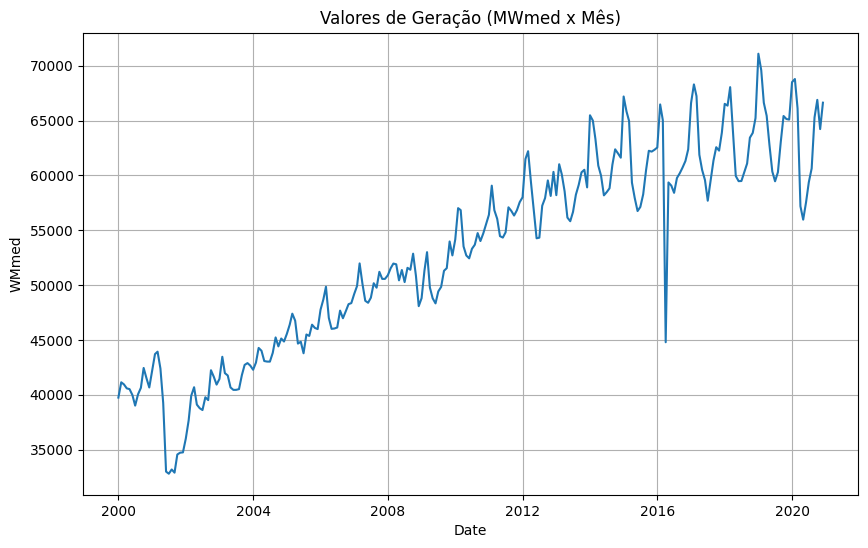

In [9]:
#Plota o série temporal
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['val_geracao'])
plt.xlabel('Date')
plt.ylabel('WMmed')
plt.title('Valores de Geração (MWmed x Mês)')
plt.grid(True)
plt.show()

### Visualização de tendência e sazonalidade

<Figure size 800x600 with 0 Axes>

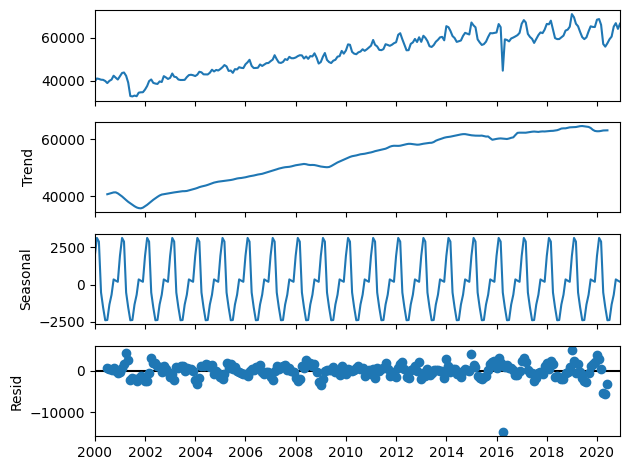

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df, period=12)
fig = plt.figure(figsize=(8,6))
fig = result.plot()

### Identificação dos outliers

In [37]:
# Função para identificar outliers usando o método Turkey (IQR)
def identify_outliers_iqr(data, threshold=1.5):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr
    outliers = (data < lower_bound) | (data > upper_bound)
    return outliers, lower_bound, upper_bound

def plot_outliers(df, outliers, lower_bound, upper_bound):
    # Criação da figura e das sub-figuras
    fig, axs = plt.subplots(2, 1, figsize=(7, 9), sharex=True)

    # Plot do primeiro gráfico
    axs[0].scatter(df.index, result.resid, label='Resíduos da Decomposição Sazonal')
    axs[0].scatter(df.index[outliers], result.resid[outliers], color='red', label='Outliers')
    axs[0].axhline(y=0, color='gray', linestyle='-', linewidth=1)
    axs[0].axhline(y=lower_bound, color='red', linestyle='--', linewidth=1, label='Limite inferior')
    axs[0].axhline(y=upper_bound, color='red', linestyle='--', linewidth=1, label='Limite superior')
    axs[0].set_ylabel('Resid')
    axs[0].set_title('Resíduos com Outliers identificados')
    axs[0].legend()

    # Plot do segundo gráfico
    axs[1].plot(df.index, df['val_geracao'], label='Valores de Geração Originais')
    axs[1].scatter(df.index[outliers], df.loc[outliers, 'val_geracao'], color='red', label='Outliers')
    axs[1].set_xlabel('Data')
    axs[1].set_ylabel('Valores de Geração')
    axs[1].set_title('Valores de Geração com Outliers Identificados')
    axs[1].legend()

    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [44]:
outliers, lower_bound, upper_bound = identify_outliers_iqr(result.resid, threshold=1.5)

print(f'Porcentagem de outliers: {np.sum(outliers.values)/outliers.size*100:.2f}%')

Porcentagem de outliers: 2.78%


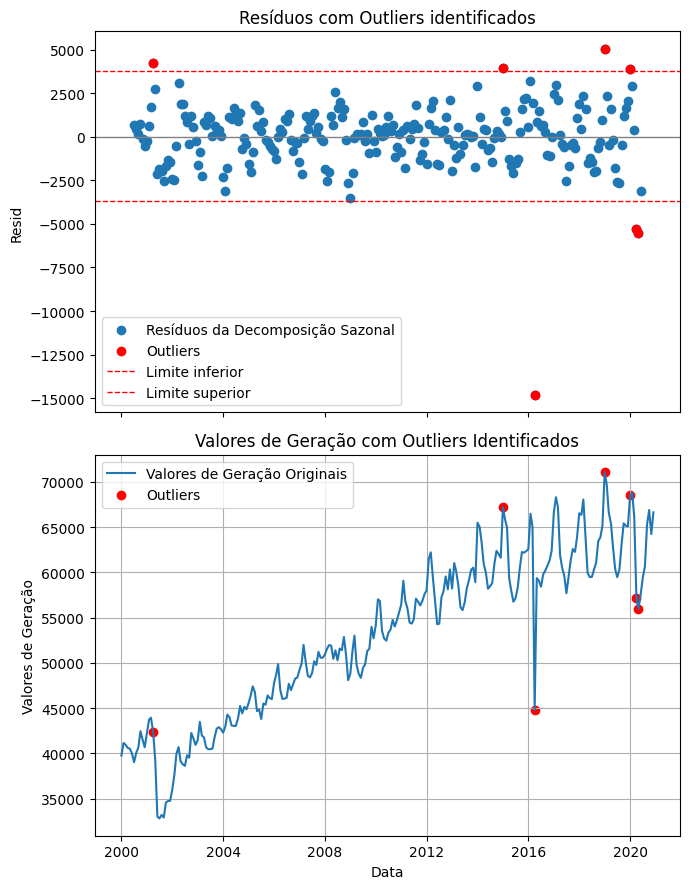

In [45]:
plot_outliers(df, outliers, lower_bound, upper_bound)

###Tratamento dos outliers

In [46]:
def replace_outliers_with_neighbors_median(data, outliers, window_size=3):
    # Cria uma cópia dos dados para evitar alterações indesejadas no original
    data_copy = data.copy()

    # Substitui os outliers pela mediana dos seus vizinhos
    for idx in outliers[outliers].index:
        # Verifica se o índice do outlier está dentro dos limites do DataFrame
        if idx - pd.Timedelta(days=window_size) >= data.index[0] and idx + pd.Timedelta(days=window_size) <= data.index[-1]:
            # Calcula a mediana dos vizinhos usando a janela especificada
            neighbor_median = data.loc[idx - pd.Timedelta(days=window_size):idx + pd.Timedelta(days=window_size+1)].median()
            # Substitui o valor do outlier pela mediana dos vizinhos
            data_copy.loc[idx] = neighbor_median
    return data_copy

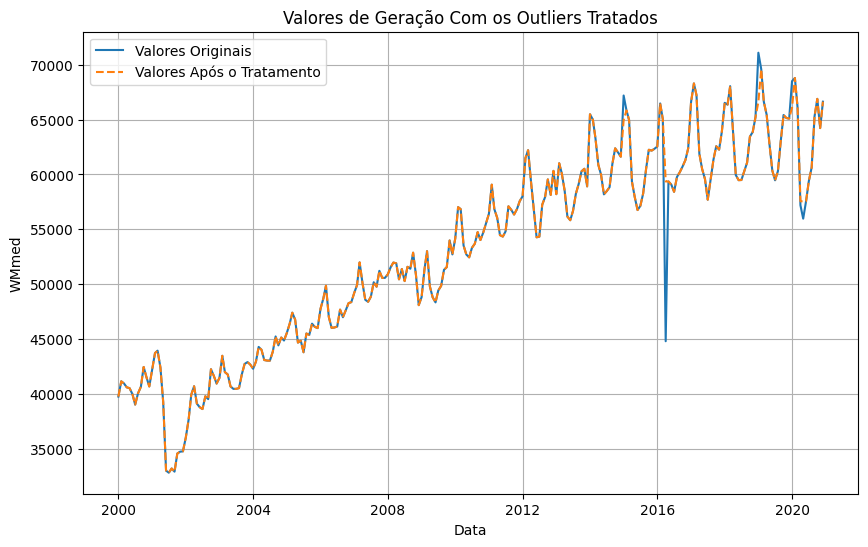

In [47]:
df_cleaned = replace_outliers_with_neighbors_median(df, outliers, window_size=70)
#A média móvel é eita somando "dias", como o nosso conjunto de dados está em meses, soma-se 70, mas quivale a uma janela de 5 amostras

#Plota o série temporal
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['val_geracao'], label='Valores Originais')
plt.plot(df_cleaned.index, df_cleaned, label='Valores Após o Tratamento', linestyle='--')
plt.xlabel('Data')
plt.ylabel('WMmed')
plt.title('Valores de Geração Com os Outliers Tratados')
plt.legend()
plt.grid(True)
plt.show()

<Figure size 800x600 with 0 Axes>

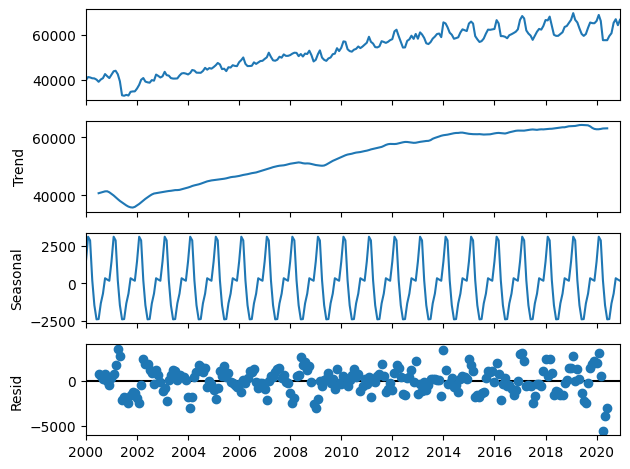

In [48]:
#Valores de Tendência e Sazonalidade após o tratamento
result_cleaned = seasonal_decompose(df_cleaned, period=12)
fig = plt.figure(figsize=(8,6))
fig = result_cleaned.plot()

#Métricas

In [72]:
# Calcula o Erro Médio Absoluto (MAE)
def _calc_mae(y_pred, y_true):
    return np.mean(np.abs(y_true - y_pred))

#Calcula o Erro Percentual Absoluto Médio (MAPE)
def _calc_mape(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Faz Calcula as duas métricas
def avaliacao(y_pred, y_true):
  return {'MAE': _calc_mae(y_pred, y_true),
          'MAPE': _calc_mape(y_pred, y_true)}

#Printa os resultados das duas métricas
def print_avaliacao(y_pred, y_true):
  aval = avaliacao(y_pred, y_true)
  for metric, value in aval.items():
    print(f"{metric}: {value:.2f}")

#Plota gráfico comparando os resultados do modelo com o groundtruth
def plot_avaliacao(df_completo, y_pred, titulo):
    # Criação da figura e das sub-figuras
    fig, axs = plt.subplots(2, 1, figsize=(7, 9))

    n_preds = len(y_pred)

    # Plot do primeiro gráfico
    axs[0].plot(df_completo.index, df_completo['val_geracao'], label='Groundtruth')
    axs[0].plot(df_completo.index[-n_preds:], y_pred, label='Previsões', color='red', linestyle='--')
    axs[0].set_ylabel('Geração (MWmed)')
    axs[0].legend()
    axs[0].grid(True)

    # Plot do segundo gráfico
    axs[1].plot(df_completo.index[-n_preds:], df_completo['val_geracao'][-n_preds:], label='Groundtruth')
    axs[1].plot(df_completo.index[-n_preds:], y_pred, label='Previsões', color='red', linestyle='--')
    axs[1].set_ylabel('Geração (MWmed)')
    axs[1].set_xlabel('Data')
    axs[1].legend()
    axs[1].grid(True)

    # Definindo as datas de início e fim para o sombreado
    data_inicio_shade = pd.Timestamp('2019-01-01')
    data_fim_shade = pd.Timestamp('2020-12-01')

    for ax in axs:
      ax.axvspan(data_inicio_shade, data_fim_shade, color='gray', alpha=0.3)

    fig.suptitle(titulo)
    plt.tight_layout()
    plt.show()

#Modelos

##Regressão polinomial

In [87]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def regressao_polinomial(y_treino, y_teste, degrees):
  x_treino = np.array(range(len(y_treino)))
  x_teste = np.array(range(len(y_treino), len(y_treino)+len(y_teste)))

  models = []
  y_treino_preds = []
  y_teste_preds = []
  for degree in degrees:
    # Transformar os recursos em polinômios
    poly_features = PolynomialFeatures(degree=degree)
    X_poly_treino = poly_features.fit_transform(x_treino.reshape(-1, 1))
    X_poly_teste = poly_features.transform(x_teste.reshape(-1, 1))

    # Treinar o modelo de regressão linear
    model = LinearRegression()
    model.fit(X_poly_treino, y_treino)

    # Calcular as previsões nos conjuntos de treinamento e teste
    y_treino_pred = model.predict(X_poly_treino)
    y_teste_pred = model.predict(X_poly_teste)
    y_treino_preds.append(y_treino_pred)
    y_teste_preds.append(y_teste_pred)

    models.append(model)
  return models, y_treino_preds, y_teste_preds

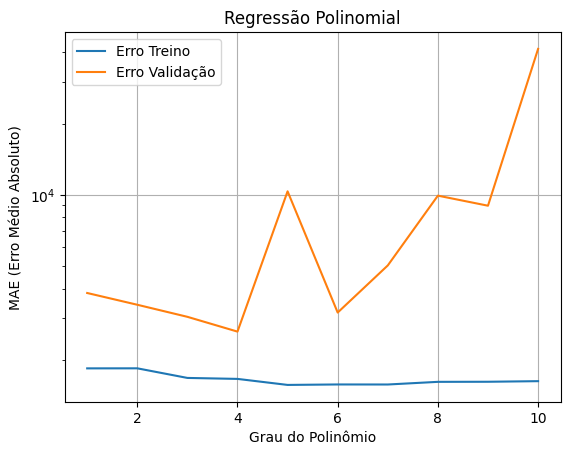

In [88]:
y_treino_1 = df_cleaned.values[:-48]
y_validacao = df_cleaned.values[-48:-24]

degrees = [_ for _ in range(1,11)]

models, y_treino_preds, y_validacao_preds = regressao_polinomial(y_treino_1, y_validacao, degrees)

mae_treino_1 = [avaliacao(y_treino_pred, y_treino_1)['MAE'] for y_treino_pred in y_treino_preds]
mae_validacao = [avaliacao(y_validacao_pred, y_validacao)['MAE'] for y_validacao_pred in y_validacao_preds]

plt.plot(degrees, mae_treino_1, label='Erro Treino')
plt.plot(degrees, mae_validacao, label='Erro Validação')
plt.xlabel('Grau do Polinômio')
plt.ylabel('MAE (Erro Médio Absoluto)')
plt.title('Regressão Polinomial')
plt.yscale('log')  # Definindo a escala logarítmica no eixo y
plt.legend()
plt.grid(True)
plt.show()

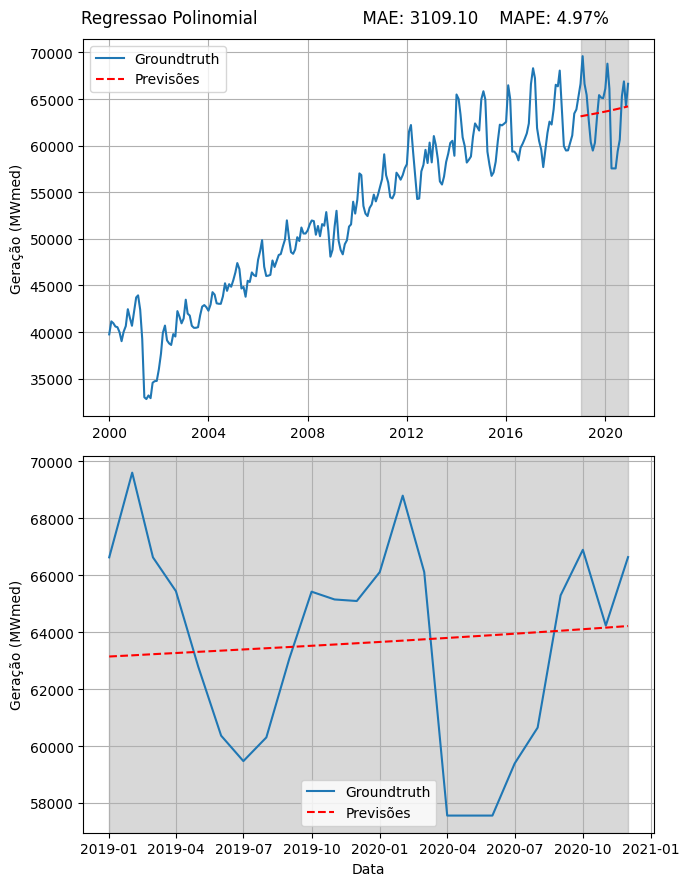

In [155]:
best_degree = np.argmin(mae_validacao)+1

y_treino_2 = df_cleaned.values[:-24]
y_test = df_cleaned.values[-24:]

models, y_treino_preds_2, y_test_preds = regressao_polinomial(y_treino_2, y_test, [best_degree])

aval_regressao = avaliacao(y_test_preds[0].reshape((1,24)), y_test.reshape((1,24)))
# print_avaliacao(y_test_preds, y_test)
titulo = f'Regressao Polinomial                    MAE: {aval_regressao["MAE"]:.2f}    MAPE: {aval_regressao["MAPE"]:.2f}%'
plot_avaliacao(df_cleaned, y_test_preds[0].flatten().tolist(), titulo)

##(S)ARIMA

In [90]:
!pip install pmdarima

In [91]:
from pmdarima import auto_arima

y_train_sarima = df_cleaned[:-24]
y_test_sarima = df_cleaned[-24:]

# Usar auto_arima para encontrar os melhores parâmetros SARIMA
sarima_model = auto_arima(y_train_sarima, seasonal=True, m=12)  # Mês é o período sazonal neste exemplo

# Exibir os parâmetros selecionados
print(sarima_model.order)
print(sarima_model.seasonal_order)

(1, 1, 0)
(1, 0, 1, 12)


In [92]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Treinar o modelo SARIMA com os parâmetros selecionados
sarima_model = SARIMAX(y_train_sarima,
                       order=sarima_model.order,
                       seasonal_order=sarima_model.seasonal_order,
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarima_result = sarima_model.fit()

# Visualizar o sumário do modelo
print(sarima_result.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                          val_geracao   No. Observations:                  228
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 12)   Log Likelihood               -1848.704
Date:                              Mon, 11 Mar 2024   AIC                           3705.408
Time:                                      00:56:22   BIC                           3718.872
Sample:                                  01-01-2000   HQIC                          3710.849
                                       - 12-01-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1735      0.053     -3.274      0.001      -0.277      -0.070
ar.S.L12       0.86

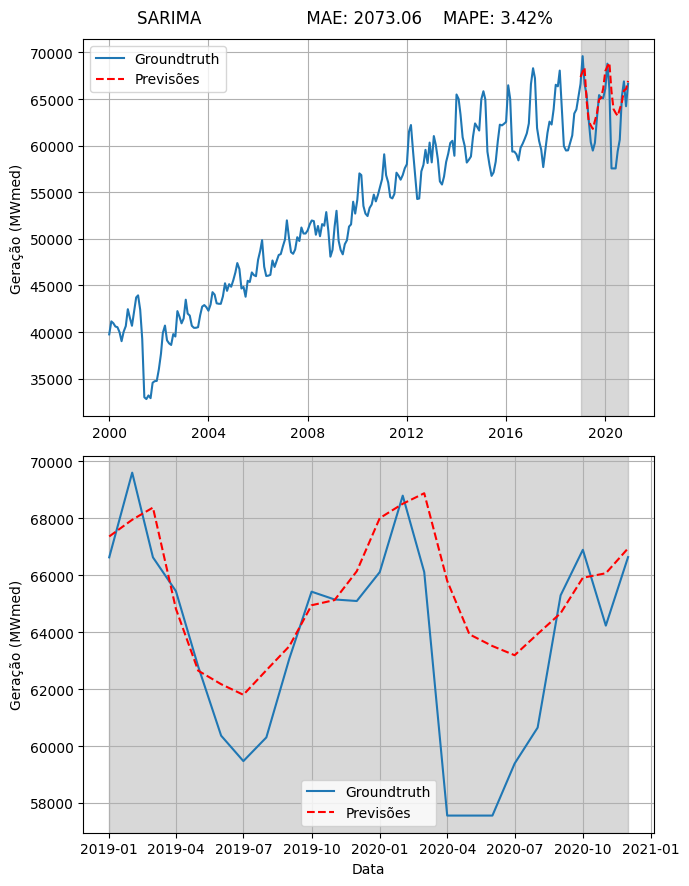

In [143]:
y_test_preds_sarima = sarima_result.predict(start=y_test_sarima.index[0], end=y_test_sarima.index[-1], dynamic=False)

aval_sarima = avaliacao(y_test_preds_sarima.values, y_test_sarima.values.reshape(1,24))
titulo_sarima = f'SARIMA                    MAE: {aval_sarima["MAE"]:.2f}    MAPE: {aval_sarima["MAPE"]:.2f}%'
plot_avaliacao(df_cleaned, y_test_preds_sarima.values, titulo_sarima)

##XGBoostRegressor

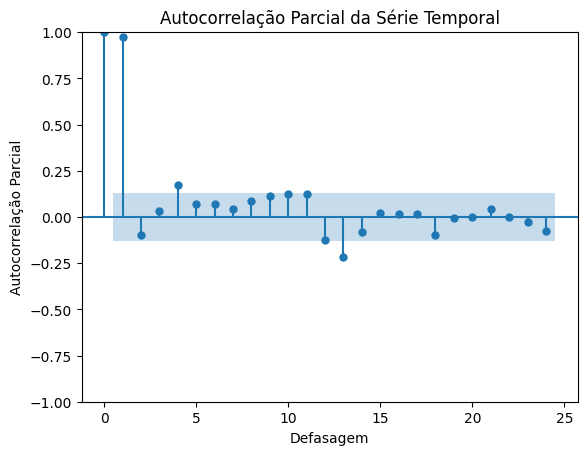

In [115]:
from statsmodels.graphics.tsaplots import plot_pacf
df_xg = df_cleaned.copy()

# Plotando o teste de autocorrelação parcial para diferentes defasagens
plot_pacf(df_xg[:-24]['val_geracao'])
plt.xlabel('Defasagem')
plt.ylabel('Autocorrelação Parcial')
plt.title('Autocorrelação Parcial da Série Temporal')
plt.show()

In [116]:
#O XGBoostRegressor é um modelo de aprendizado de máquinas para regressão. Para usa-lo com séries
#temporais é necessário modificar um pouco os dados, a fim de que cada amostra carregue informações
#temporais. Faremos isso adicionando colunas de "lag"

for l in range(1,13):
  df_xg[f'lag{l}'] = df_xg['val_geracao'].shift(l)
df_xg['n_mes'] = df_xg.index.month

df_xg_train = df_xg[:-24].dropna()
df_xg_test = df_xg[-24:].dropna()

df_xg_train.shape, df_xg_test.shape

((216, 14), (24, 14))

In [117]:
train_coluns = [f'lag{l}' for l in range(1,13)]

X_train = df_xg_train.loc[:, train_coluns].values
y_train = df_xg_train.loc[:, ['val_geracao']].values
X_test = df_xg_test.loc[:, train_coluns].values
y_test = df_xg_test.loc[:, ['val_geracao']].values

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((216, 12), (216, 1), (24, 12), (24, 1))

In [118]:
from xgboost import XGBRegressor

modelo_xgb = XGBRegressor(objective="reg:linear", n_estimators=1000)
modelo_xgb.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:13:39] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

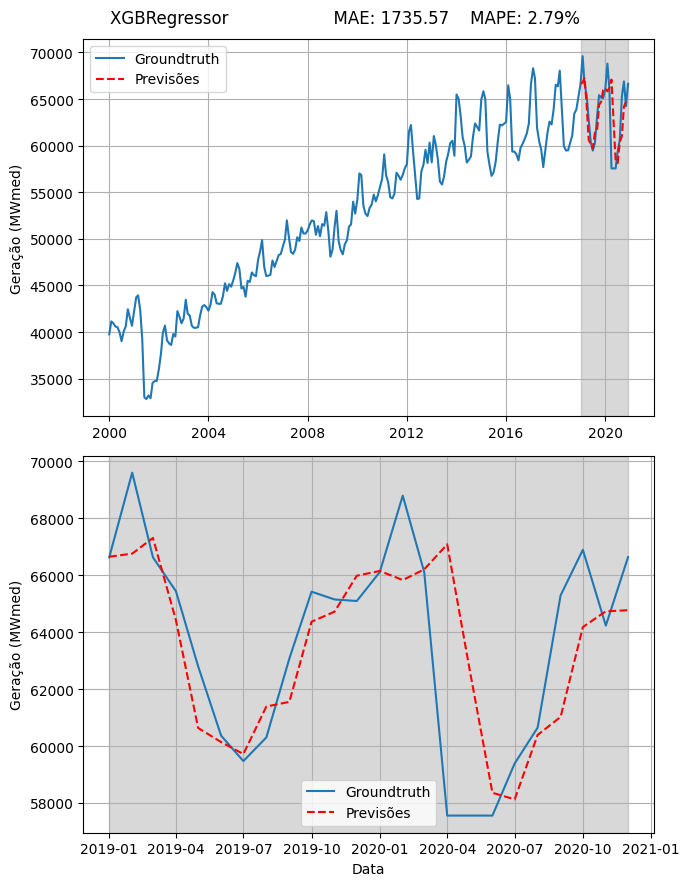

In [136]:
y_preds_xg = modelo_xgb.predict(X_test)

aval_xg = avaliacao(y_preds_xg, y_test.reshape((1, 24)))
titulo_xg = f'XGBRegressor                    MAE: {aval_xg["MAE"]:.2f}    MAPE: {aval_xg["MAPE"]:.2f}%'
plot_avaliacao(df_cleaned, y_preds_xg, titulo_xg)

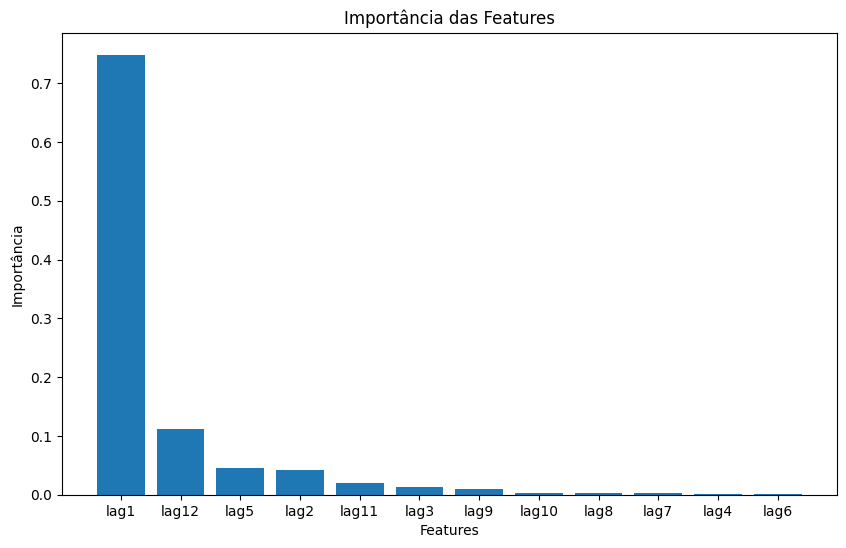

In [156]:
importancias = modelo_xgb.feature_importances_

# Associa as importâncias aos nomes das features
nomes_features = df_xg.columns[1:]
importancias_por_feature = dict(zip(nomes_features, importancias))

# Ordena as importâncias das features
importancias_ordenadas = sorted(importancias_por_feature.items(), key=lambda x: x[1], reverse=True)

# Extrai os nomes das features e suas importâncias ordenadas
nomes_features_ordenados = [x[0] for x in importancias_ordenadas]
importancias_ordenadas = [x[1] for x in importancias_ordenadas]

# Crie o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(nomes_features_ordenados, importancias_ordenadas)
plt.xlabel('Features')
plt.ylabel('Importância')
plt.title('Importância das Features')
plt.show()

##Comparação Final

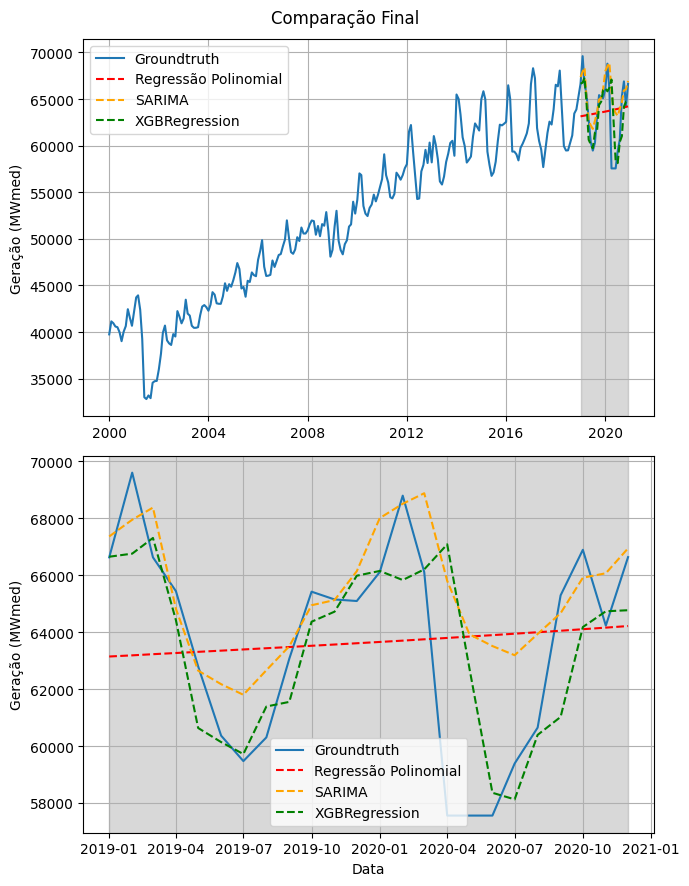

In [162]:

# Criação da figura e das sub-figuras
fig, axs = plt.subplots(2, 1, figsize=(7, 9))

n_preds = 24

# Plot do primeiro gráfico
axs[0].plot(df_cleaned.index, df_cleaned['val_geracao'], label='Groundtruth')
axs[0].plot(df_cleaned.index[-n_preds:], y_test_preds[0].flatten().tolist(), label='Regressão Polinomial', color='red', linestyle='--')
axs[0].plot(df_cleaned.index[-n_preds:], y_test_preds_sarima.values, label='SARIMA', color='orange', linestyle='--')
axs[0].plot(df_cleaned.index[-n_preds:], y_preds_xg, label='XGBRegression', color='green', linestyle='--')
axs[0].set_ylabel('Geração (MWmed)')
axs[0].legend()
axs[0].grid(True)

# Plot do segundo gráfico
axs[1].plot(df_cleaned.index[-n_preds:], df_cleaned['val_geracao'][-n_preds:], label='Groundtruth')
axs[1].plot(df_cleaned.index[-n_preds:], y_test_preds[0].flatten().tolist(), label='Regressão Polinomial', color='red', linestyle='--')
axs[1].plot(df_cleaned.index[-n_preds:], y_test_preds_sarima.values, label='SARIMA', color='orange', linestyle='--')
axs[1].plot(df_cleaned.index[-n_preds:], y_preds_xg, label='XGBRegression', color='green', linestyle='--')
axs[1].set_ylabel('Geração (MWmed)')
axs[1].set_xlabel('Data')
axs[1].legend()
axs[1].grid(True)

# Definindo as datas de início e fim para o sombreado
data_inicio_shade = pd.Timestamp('2019-01-01')
data_fim_shade = pd.Timestamp('2020-12-01')

for ax in axs:
  ax.axvspan(data_inicio_shade, data_fim_shade, color='gray', alpha=0.3)

fig.suptitle('Comparação Final')
plt.tight_layout()
plt.show()